# Embendings 

* [Motivation](#Motivation)
* [Data Preparation](#Data-Preparation)
* [Word2Vec Model](#Word2Vec-Model)
    * [Similar words based on Word2Vec model](#Similar-words-based-on-Word2Vec-model)
* [Prediction model using context window](#Prediction-model-using-context-window)
* [Glove](#Glove)
* [](#)
* [](#)
* [](#)
* [](#)

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from gensim.models import word2vec
pd.options.display.max_colwidth = 200

%matplotlib inline

## Motivation

Since text is unstructured and noise, the embemdings representation allow us to represent their information in a vectorial space. Word2Vec, Glove and FastText are algorithms that create those vectorial spaces using the contextual similarity and semantic between words. In contrast with the bags of words which just capture the relation between closest words and not the global semantic relationship in a document. 
The aim of this kind of techniques is predicting instead of counting.
https://www.aclweb.org/anthology/P14-1023.pdf

## Data Preparation

In [2]:
corpus = ['The sky is blue and beautiful :) .',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    ,
          'The owls live in the forest',
          'Today is raining cats and dogs '
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals', 'animals', 'weather']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})     #Converting the dictionary in DataFrame
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful :) .,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beautiful today,weather
7,The dog is lazy but the brown fox is quick!,animals
8,The owls live in the forest,animals
9,Today is raining cats and dogs,weather


In [3]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)# remove special characters: 
    doc = doc.lower()                               # transform to lower case
    doc = doc.strip()                               # remove \whitespaces
    tokens = wpt.tokenize(doc)                      # tokenize document
    filtered_tokens = [token for token in tokens if token not in stop_words]# filter stopwords out of document
    doc = ' '.join(filtered_tokens)                 # re-create document from filtered tokens
    return doc


normalize_corpus = np.vectorize(normalize_document)  # vectorized function which takes a nested sequence of objects and returns a single numpy array 
corpus_df['norm_corpus']=normalize_corpus(corpus)
corpus_df

,Document,Category,norm_corpus
0,The sky is blue and beautiful :) .,weather,sky blue beautiful
1,Love this blue and beautiful sky!,weather,love blue beautiful sky
2,The quick brown fox jumps over the lazy dog.,animals,quick brown fox jumps lazy dog
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,kings breakfast sausages ham bacon eggs toast beans
4,"I love green eggs, ham, sausages and bacon!",food,love green eggs ham sausages bacon
5,The brown fox is quick and the blue dog is lazy!,animals,brown fox quick blue dog lazy
6,The sky is very blue and the sky is very beautiful today,weather,sky blue sky beautiful today
7,The dog is lazy but the brown fox is quick!,animals,dog lazy brown fox quick
8,The owls live in the forest,animals,owls live forest
9,Today is raining cats and dogs,weather,today raining cats dogs


## Word2Vec Model

Created by Google in 2013, this is a distributed and continuous dense vector representations of words.

In [4]:
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in corpus_df['norm_corpus']]

# Set the parameters
feature_size = 15            # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1           # Minimum word count                        
sample = 1e-3                # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, 
                              size=feature_size, 
                              window=window_context, 
                              min_count = min_word_count,
                              sample=sample, 
                              iter=100)

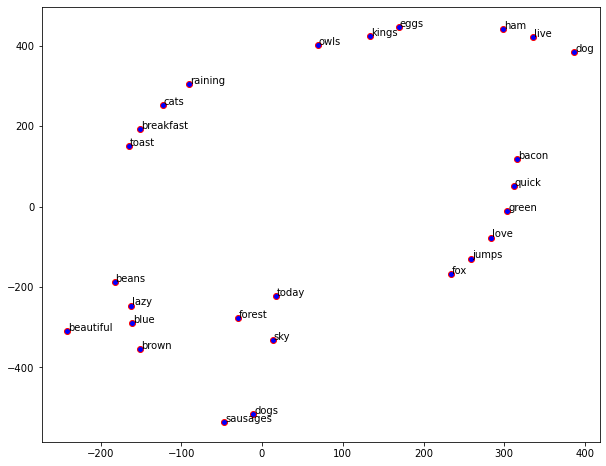

In [5]:
# visualize embeddings
from sklearn.manifold import TSNE #Visualizing tool t-distributed Stochastic Neighbor Embedding

words = w2v_model.wv.index2word #list of word-vectors
wvs = w2v_model.wv[words]       #list of vectors

tsne = TSNE(n_components=2, 
            random_state=0, 
            n_iter=5000, 
            perplexity=2)

np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(10, 8))
plt.scatter(T[:, 0], T[:, 1], c='blue', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [6]:
words

['sky',
 'blue',
 'beautiful',
 'quick',
 'brown',
 'fox',
 'lazy',
 'dog',
 'love',
 'sausages',
 'ham',
 'bacon',
 'eggs',
 'today',
 'jumps',
 'kings',
 'breakfast',
 'toast',
 'beans',
 'green',
 'owls',
 'live',
 'forest',
 'raining',
 'cats',
 'dogs']

In [7]:
wvs 

array([[ 0.00973868,  0.02359959,  0.02906081,  0.00521444,  0.02447689,
         0.01905392, -0.01101429,  0.01442075, -0.00945793, -0.0331611 ,
        -0.02138757, -0.006775  ,  0.02211236, -0.02964629,  0.0296037 ],
       [-0.00530245, -0.0186872 , -0.01585512,  0.0035948 ,  0.00217126,
        -0.00613843, -0.00851777,  0.01351901,  0.01598773, -0.00376979,
        -0.01800086,  0.02075105,  0.03323003, -0.01213446, -0.01571128],
       [-0.00044705, -0.03023454, -0.02432572, -0.01163972,  0.02830653,
        -0.01171707, -0.02337069,  0.00463958,  0.02646026,  0.02645923,
        -0.01405716,  0.00011136, -0.02059162,  0.02227462, -0.00287884],
       [ 0.03186117, -0.00899675,  0.01310622,  0.00186419, -0.02983293,
        -0.02757345,  0.00113254, -0.02598183,  0.01656358, -0.02661136,
         0.01498245,  0.01780995,  0.02793815, -0.01483441,  0.01693268],
       [-0.027879  , -0.01068688,  0.03182741, -0.01975468,  0.0209766 ,
        -0.00388746,  0.01096697, -0.00892213, 

In [8]:
w2v_model.wv['sky'] #Representation of the first word

array([ 0.00973868,  0.02359959,  0.02906081,  0.00521444,  0.02447689,
        0.01905392, -0.01101429,  0.01442075, -0.00945793, -0.0331611 ,
       -0.02138757, -0.006775  ,  0.02211236, -0.02964629,  0.0296037 ],
      dtype=float32)

In [9]:
#we need to get the document level embeddings from each of the words present in each document.
#average out the word embeddings for each word in a document
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)


# get document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, 
                                             model=w2v_model, 
                                             num_features=feature_size)
          

<ipython-input-9-3b39b39ddf33>:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  feature_vector = np.add(feature_vector, model[word])


In [10]:
Vector_representation = pd.DataFrame(w2v_feature_array)
Vector_representation

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.001330,-0.008441,-0.003707,-0.000943,0.018318,0.000399,-0.014301,0.010860,0.010997,-0.003491,-0.017815,0.004696,0.011584,-0.006502,0.003671
1,-0.000495,-0.011995,-0.004789,0.004300,0.011628,-0.004118,-0.009827,0.004168,0.010553,-0.005687,-0.005489,0.010582,0.000496,-0.003781,0.006423
2,0.001887,-0.007465,0.000617,0.005438,-0.008574,-0.006014,0.000254,-0.010487,0.007603,-0.019263,0.012230,0.010121,0.010589,-0.012266,-0.010161
3,0.016454,-0.002492,0.007208,-0.000538,-0.001118,0.012580,-0.008860,-0.003072,0.011947,-0.014386,-0.007250,-0.001320,0.002516,-0.001195,0.010179
4,0.009921,-0.012690,-0.004650,-0.006585,-0.008671,0.006650,-0.003117,-0.006868,0.003655,-0.017998,0.001849,0.001760,-0.008441,0.004092,0.014828
5,0.000850,-0.007049,-0.001213,0.003698,-0.006455,-0.007562,0.002804,-0.007018,0.013631,-0.017606,0.003963,0.011568,0.019524,-0.011810,-0.009215
6,-0.001662,0.005511,0.004937,0.004892,0.013895,-0.000323,-0.009066,0.011410,0.001158,-0.009116,-0.011942,0.001026,0.009395,-0.005287,0.007364
7,0.002080,-0.004721,0.001716,0.003718,-0.008180,-0.007847,0.005068,-0.011126,0.013159,-0.020373,0.008355,0.009731,0.016783,-0.011745,-0.007916
8,0.016669,-0.004721,-0.004455,0.002647,-0.005796,0.023165,0.005443,-0.004890,-0.010544,0.003172,-0.007369,-0.005109,0.008765,-0.009620,-0.000651
9,0.004030,0.019148,0.007538,-0.002229,0.004750,0.007844,0.007927,-0.003059,0.000108,0.007174,-0.010114,-0.005470,-0.016027,0.000573,-0.012847


The Affinity Propagation algorithm will be used to cluster those documents since its based on the concept of *message passing* between data points and does not need the number of clusters as an explicit input.

In [11]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array) #The transformed vectors are the input to the unsupervised algorithm
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
corpus_df=pd.concat([corpus_df, cluster_labels], axis=1)

/Users/anmarphy/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "


In [12]:
ap.labels_

array([0, 0, 2, 1, 1, 2, 0, 2, 1, 3])

In [13]:
corpus_df['ClusterLabel'].value_counts()

2    3
1    3
0    3
3    1
Name: ClusterLabel, dtype: int64

In [14]:
corpus_df 
#due to the ambiguity of the last document it is classified closer than the animals instances than the weather ones

,Document,Category,norm_corpus,ClusterLabel
0,The sky is blue and beautiful :) .,weather,sky blue beautiful,0
1,Love this blue and beautiful sky!,weather,love blue beautiful sky,0
2,The quick brown fox jumps over the lazy dog.,animals,quick brown fox jumps lazy dog,2
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,kings breakfast sausages ham bacon eggs toast beans,1
4,"I love green eggs, ham, sausages and bacon!",food,love green eggs ham sausages bacon,1
5,The brown fox is quick and the blue dog is lazy!,animals,brown fox quick blue dog lazy,2
6,The sky is very blue and the sky is very beautiful today,weather,sky blue sky beautiful today,0
7,The dog is lazy but the brown fox is quick!,animals,dog lazy brown fox quick,2
8,The owls live in the forest,animals,owls live forest,1
9,Today is raining cats and dogs,weather,today raining cats dogs,3


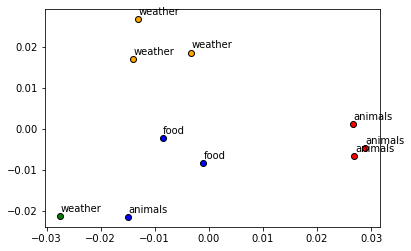

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
categories = list(corpus_df['Category']) 
plt.figure(figsize=(6,4))

for i in range(len(labels)):
    label = labels[i]
    color = 'orange' if label == 0 else 'blue' if label == 1  else 'red' if label==2  else 'green'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0, 0), textcoords='offset points')

### Similar words based on Word2Vec model

In [16]:
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/anmarphy/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [17]:
from nltk.corpus import gutenberg
from string import punctuation

bible = gutenberg.sents('bible-kjv.txt') #sentences tokenizer
remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible] #remove numbers and puctuation
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2] #removing sentences with less than 2 words

print('Total lines:', len(bible))
print('\nSample line:', bible[8])
print('Total lines:', len(norm_bible))
print('\nProcessed line:', norm_bible[8])

Total lines: 30103

Sample line: ['1', ':', '5', 'And', 'God', 'called', 'the', 'light', 'Day', ',', 'and', 'the', 'darkness', 'he', 'called', 'Night', '.']
Total lines: 29251

Processed line: god called light day darkness called night


In [18]:
wpt = nltk.WordPunctTokenizer() # tokenize sentences in corpus
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

## Word2Vec model
feature_size = 100    
window_context = 30                                                                                           
min_word_count = 1                         
sample = 1e-3   

w2v_model = word2vec.Word2Vec(tokenized_corpus, 
                              size=feature_size, 
                              window=window_context, 
                              min_count=min_word_count,
                              sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine', 'love']}
similar_words

{'god': ['worldly', 'lord', 'reasonable', 'promised', 'established'],
 'jesus': ['peter', 'messias', 'immediately', 'synagogue', 'apostles'],
 'noah': ['shem', 'ham', 'japheth', 'kenan', 'enosh'],
 'egypt': ['pharaoh', 'egyptians', 'bondage', 'rod', 'flowing'],
 'john': ['james', 'baptist', 'devine', 'tetrarch', 'zebedee'],
 'gospel': ['christ', 'faith', 'preach', 'repentance', 'afflictions'],
 'moses': ['elisheba', 'congregation', 'joshua', 'children', 'aaron'],
 'famine': ['pestilence', 'sword', 'peril', 'overtaketh', 'blasting'],
 'love': ['humbleness', 'unfeigned', 'hate', 'likeminded', 'longsuffering']}

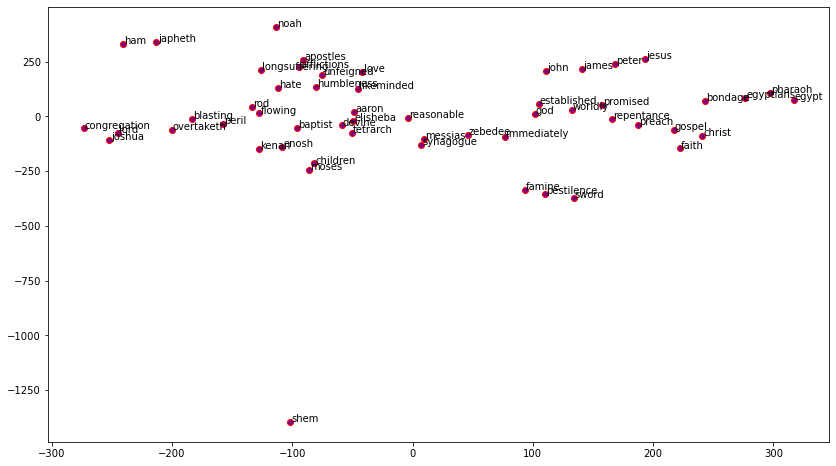

In [19]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='purple', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Prediction model using context window

There are two different model architectures which can be leveraged by Word2Vec to create these word embedding representations.
* The Continuous Bag of Words (CBOW) Model
* The Skip-gram Model


The CBOW model tries to predict the current target word (the center word) based on the surrounding words (context window). E.g: 'The quick brown fox jumps over the lazy dog', this can be pairs of (context_window, target_word) where if we consider a context window of size 2, we would have examples like ([quick, fox], brown), ([the, brown], quick), ([the, dog], lazy) and so on. 

In [20]:
# 1. Building the corpus vocabulary
from tensorflow.keras.preprocessing import text
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}# build a vocabulary-dictionary of unique words

# docs as nested lists of id's of words
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]

vocab_size = len(word2id)
embed_size = 100
window_size = 3 # context window size!

#Each word is indexed, and that representation is used to rewrite the sentences
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:16])
print('list of numeric sequences: ',wids[:2])

Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10), ('man', 11), ('israel', 12), ('king', 13), ('son', 14), ('hath', 15), ('people', 16)]
list of numeric sequences:  [[13, 1154, 5766], [154, 2450, 13, 1154, 5766]]


In [21]:
print('list of preprocessed sequences: ',norm_bible[0:2])

list of preprocessed sequences:  ['king james bible', 'old testament king james bible']


In [22]:
#2. Build a CBOW (context, target) generator
##We are trying to predict the target center word Y based on this context (window size).

def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = to_categorical(label_word, vocab_size)
            yield (x, y)
            
            
# Test this out for some samples
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print( 'Trial: ',i,'Context (X):',[id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Trial:  0 Context (X): ['earth', 'without', 'form', 'darkness', 'upon', 'face'] -> Target (Y): void
Trial:  1 Context (X): ['without', 'form', 'void', 'upon', 'face', 'deep'] -> Target (Y): darkness
Trial:  2 Context (X): ['god', 'saw', 'light', 'god', 'divided', 'light'] -> Target (Y): good
Trial:  3 Context (X): ['saw', 'light', 'good', 'divided', 'light', 'darkness'] -> Target (Y): god
Trial:  4 Context (X): ['god', 'called', 'light', 'darkness', 'called', 'night'] -> Target (Y): day
Trial:  5 Context (X): ['god', 'said', 'let', 'midst', 'waters', 'let'] -> Target (Y): firmament
Trial:  6 Context (X): ['said', 'let', 'firmament', 'waters', 'let', 'divide'] -> Target (Y): midst
Trial:  7 Context (X): ['let', 'firmament', 'midst', 'let', 'divide', 'waters'] -> Target (Y): waters
Trial:  8 Context (X): ['firmament', 'midst', 'waters', 'divide', 'waters', 'waters'] -> Target (Y): let
Trial:  9 Context (X): ['god', 'made', 'firmament', 'waters', 'firmament', 'waters'] -> Target (Y): divi

## Glove
references: https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010 
https://github.com/stanfordnlp/GloVe

GloVe is a word vector technique . Its advantage  is that, unlike Word2vec, GloVe does not rely just on local statistics (local context information of words), but incorporates global statistics (word co-occurrence) to obtain word vectors. 

Word2Vec: you get a large corpus, and make a dataset of tuples, where each tuple contains (some word x, a word in the context of x). the semantics learnt for a given word, is only affected by the surrounding words. Word2vec which captures local statistics do very well in analogy tasks. 

Glove: You can derive semantic relationships between words from the co-occurrence matrix.



## References
* https://jdvelasq.github.io/courses/
* https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
* https://www.kdnuggets.com/2018/04/robust-word2vec-models-gensim.html
* https://radimrehurek.com/gensim/models/word2vec.html
* https://nbviewer.jupyter.org/github/AprendizajeProfundo/Diplomado/blob/master/Temas/Módulo%208-%20Aprendizaje%20Profundo%20II/1.%20Procesamiento%20de%20Lenguaje%20natural/Cuadernos/nlp_word2vec.ipynb
* https://www.kdnuggets.com/2018/04/implementing-deep-learning-methods-feature-engineering-text-data-cbow.html